In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


In [2]:
import json
import networkx as nx
import copy

def load_data_from_file(filename):
    """
    Load a dictionary of graphs from JSON file.
    """
    with open(filename, "r") as file_handle:
        string_dict = json.load(file_handle)
    return _load_data_from_string_dict(string_dict)

def load_data_from_string(json_string):
    """
    Load a dictionary of graphs from JSON string.
    """
    string_dict = json.loads(json_string)
    return _load_data_from_string_dict(string_dict)

def _load_data_from_string_dict(string_dict):
    result_dict = {}
    for key in string_dict:

        data = copy.deepcopy(string_dict[key])

        if 'edges' in data:
            data["links"] = data.pop("edges")

        graph = nx.node_link_graph(data)
        result_dict[key] = graph
    return result_dict

def write_data_to_json_string(graph_dict, **kwargs):
    """
    Write dictionary of graphs to JSON string.
    """
    json_string = json.dumps(graph_dict, default=nx.node_link_data, **kwargs)
    return json_string


def write_data_to_json_file(graph_dict, filename, **kwargs):
    """
    Write dictionary of graphs to JSON file.
    """
    with open(filename, "w") as file_handle:
        file_handle.write(write_data_to_json_string(graph_dict, **kwargs))

First, load unique data points

In [3]:
train_data = load_data_from_file("../../data/graph_data.json") # dictionary of SMILES and values are graphs
embeddings = pd.read_csv('../../embedding/final_embedding_dim30.csv')

/project/ai4s-hackathon/R2S2/shrihan/venvs/shri_gnnpytorch/lib/python3.11/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


In [4]:
# Embedding IDs
embedded_atoms = list(embeddings['Atoms'])
embedded_orbitals = list(embeddings['Orbital'])

embedded_IDs = [a+','+o for a,o in zip(embedded_atoms, embedded_orbitals)]

# Embedding vectors
embedded_vectors = []

for i in range(len(embeddings)):
  a = list(np.fromstring(embeddings.loc[i,'Embeddings'].replace('\n','').strip('[]'), sep=' '))
  if len(a)>31: # Noble gas elements?
    a = list(a[-31:])

  embedded_vectors.append(a)

In [5]:
embedded_IDs.index('Co,3p')

60

In [105]:
embedded_IDs

['Li,1s',
 'B,1s',
 'C,1s',
 'N,1s',
 'O,1s',
 'F,1s',
 'Ne,1s',
 'Na,1s',
 'Mg,1s',
 'P,1s',
 'S,1s',
 'Si,2p',
 'Mg,2p3/2',
 'Al,2p3/2',
 'Si,2p3/2',
 'P,2p3/2',
 'S,2p3/2',
 'Cl,2p3/2',
 'Ar,2p3/2',
 'K,2p3/2',
 'Ca,2p3/2',
 'Ti,2p3/2',
 'V,2p3/2',
 'Cr,2p3/2',
 'Mn,2p3/2',
 'Fe,2p3/2',
 'Co,2p3/2',
 'Ni,2p3/2',
 'Cu,2p3/2',
 'Zn,2p3/2',
 'As,2p3/2',
 'Se,2p3/2',
 'Ne,2s',
 'Na,2s',
 'Mg,2s',
 'P,2s',
 'S,2s',
 'Cl,2s',
 'Ar,2s',
 'Ca,2s',
 'Ge,3d',
 'As,3d',
 'Se,3d',
 'Zn,3d5/2',
 'Ga,3d5/2',
 'Br,3d5/2',
 'Kr,3d5/2',
 'Sr,3d5/2',
 'Mo,3d5/2',
 'Rh,3d5/2',
 'Ag,3d5/2',
 'Cd,3d5/2',
 'Sn,3d5/2',
 'Sb,3d5/2',
 'Te,3d5/2',
 'I,3d5/2',
 'Xe,3d5/2',
 'Cs,3d5/2',
 'Ba,3d5/2',
 'Ti,3p',
 'Co,3p',
 'Ni,3p',
 'Cu,3p',
 'Cd,3p',
 'Ca,3p3/2',
 'Zn,3p3/2',
 'Br,3p3/2',
 'Kr,3p3/2',
 'Rb,3p3/2',
 'Sr,3p3/2',
 'Xe,3p3/2',
 'Cs,3p3/2',
 'Co,3s',
 'Ni,3s',
 'Cu,3s',
 'As,3s',
 'Br,3s',
 'Kr,3s',
 'Xe,3s',
 'Te,4d',
 'Cd,4d5/2',
 'In,4d5/2',
 'Sn,4d5/2',
 'I,4d5/2',
 'Xe,4d5/2',
 'Ba,4d5/2',
 'Hg,

In [104]:
embedded_vectors

[[-0.9012349,
  0.45608097,
  -1.4500529,
  -0.6898789,
  -1.8567122,
  1.1705838,
  2.7408226,
  -2.6115437,
  1.5616844,
  1.3683808,
  8.815499,
  -15.821081,
  -24.882704,
  -6.8084693,
  5.2303557,
  11.218215,
  -11.258187,
  -2.4736776,
  4.7199664,
  6.813945,
  4.8806677,
  15.647373,
  4.0903387,
  -9.770783,
  4.5754175,
  -19.578485,
  14.652984,
  -3.5714178,
  2.821434,
  19.832817,
  0.5912423],
 [0.7674839,
  -1.064584,
  1.375875,
  4.891208,
  -6.2485213,
  -5.3378854,
  -9.743286,
  -7.1295543,
  -7.2503514,
  -5.9234424,
  34.3219,
  0.50389177,
  12.557785,
  8.772207,
  7.5875063,
  11.153434,
  1.7064008,
  1.3259706,
  -6.412762,
  -1.4207672,
  -2.8323903,
  0.7030863,
  0.46015185,
  -3.0336118,
  0.718885,
  1.8099856,
  -5.344662,
  -2.523306,
  0.33080423,
  9.38679,
  0.5912423],
 [1.4762408,
  -0.5725381,
  -3.6370533,
  -3.3818793,
  16.813614,
  7.617602,
  26.004871,
  17.776337,
  -4.186435,
  8.30591,
  14.559387,
  1.0026258,
  5.540443,
  0.8814885

In [100]:
# get all the unique atom types, orbitals and their respective binding energies

atoms = []
charges = []
orbs = []
energies = []


for mol in train_data:
    graph = train_data[mol]

    atom = list(nx.get_node_attributes(graph, "atom_type").values())
    charge = list(nx.get_node_attributes(graph, "formal_charge").values())
    orb = list(nx.get_node_attributes(graph, "orbitals").values())
    energy = list(nx.get_node_attributes(graph, "binding_energies").values())

    for i in range(len(orb)):
        for j in range(len(orb[i])):
            if energy[i][j]!=-1:
                atoms.append(atom[i])
                charges.append(charge[i])
                orbs.append(orb[i][j])
                energies.append(energy[i][j])

# Also get embedding vectors for each species, if embedding exists
ids = [a+','+o for a,o in zip(atoms, orbs)]

states = []

for i in range(len(ids)):
  id = ids[i]
  if id in embedded_IDs:
    states.append(embedded_vectors[embedded_IDs.index(id)])
  else:
    print('No embedding for', id)
    states.append([0]*31)

No embedding for Tl,4f7/2


In [101]:
embedded_IDs

['Li,1s',
 'B,1s',
 'C,1s',
 'N,1s',
 'O,1s',
 'F,1s',
 'Ne,1s',
 'Na,1s',
 'Mg,1s',
 'P,1s',
 'S,1s',
 'Si,2p',
 'Mg,2p3/2',
 'Al,2p3/2',
 'Si,2p3/2',
 'P,2p3/2',
 'S,2p3/2',
 'Cl,2p3/2',
 'Ar,2p3/2',
 'K,2p3/2',
 'Ca,2p3/2',
 'Ti,2p3/2',
 'V,2p3/2',
 'Cr,2p3/2',
 'Mn,2p3/2',
 'Fe,2p3/2',
 'Co,2p3/2',
 'Ni,2p3/2',
 'Cu,2p3/2',
 'Zn,2p3/2',
 'As,2p3/2',
 'Se,2p3/2',
 'Ne,2s',
 'Na,2s',
 'Mg,2s',
 'P,2s',
 'S,2s',
 'Cl,2s',
 'Ar,2s',
 'Ca,2s',
 'Ge,3d',
 'As,3d',
 'Se,3d',
 'Zn,3d5/2',
 'Ga,3d5/2',
 'Br,3d5/2',
 'Kr,3d5/2',
 'Sr,3d5/2',
 'Mo,3d5/2',
 'Rh,3d5/2',
 'Ag,3d5/2',
 'Cd,3d5/2',
 'Sn,3d5/2',
 'Sb,3d5/2',
 'Te,3d5/2',
 'I,3d5/2',
 'Xe,3d5/2',
 'Cs,3d5/2',
 'Ba,3d5/2',
 'Ti,3p',
 'Co,3p',
 'Ni,3p',
 'Cu,3p',
 'Cd,3p',
 'Ca,3p3/2',
 'Zn,3p3/2',
 'Br,3p3/2',
 'Kr,3p3/2',
 'Rb,3p3/2',
 'Sr,3p3/2',
 'Xe,3p3/2',
 'Cs,3p3/2',
 'Co,3s',
 'Ni,3s',
 'Cu,3s',
 'As,3s',
 'Br,3s',
 'Kr,3s',
 'Xe,3s',
 'Te,4d',
 'Cd,4d5/2',
 'In,4d5/2',
 'Sn,4d5/2',
 'I,4d5/2',
 'Xe,4d5/2',
 'Ba,4d5/2',
 'Hg,

Encode these data points, both atomic number and quantum numbers for orbitals

In [7]:
atom_dict = {
 'Li': 3,
 'B': 5,
 'C': 6,
 'N': 7,
 'O': 8,
 'F': 9,
 'Ne': 10,
 'Na': 11,
 'Mg': 12,
 'Al': 13,
 'Si': 14,
 'P': 15,
 'S': 16,
 'Cl': 17,
 'Ar': 18,
 'K': 19,
 'Ca': 20,
 'Ti': 22,
 'V': 23,
 'Cr': 24,
 'Mn': 25,
 'Fe': 26,
 'Co': 27,
 'Ni': 28,
 'Cu': 29,
 'Zn': 30,
 'Ga': 31,
 'Ge': 32,
 'As': 33,
 'Se': 34,
 'Br': 35,
 'Kr': 36,
 'Rb': 37,
 'Sr': 38,
 'Mo': 42,
 'Rh': 45,
 'Ag': 47,
 'Cd': 48,
 'In': 49,
 'Sn': 50,
 'Sb': 51,
 'Te': 52,
 'I': 53,
 'Xe': 54,
 'Cs': 55,
 'Ba': 56,
 'W': 74,
 'Re': 75,
 'Hg': 80,
 'Tl': 81,
 'Pb': 82,
 'Bi': 83,
 'U': 92
}

orb_dict = {
 '2p': [2, 1, 0],
 '2p3/2': [2, 1, 1.5],
 '4p3/2': [4, 1, 1.5],
 '3d5/2': [3, 2, 2.5],
 '3d': [3, 2, 0],
 '5p3/2': [5, 1, 1.5],
 '2s': [2, 0, 0],
 '1s': [1, 0, 0],
 '4s': [4, 0, 0],
 '3p': [3, 1, 0],
 '5d5/2': [5, 2, 2.5],
 '5s': [5, 0, 0],
 '3s': [3, 0, 0],
 '3p3/2': [3, 1, 1.5],
 '4d5/2': [4, 2, 2.5],
 '4d': [4, 2, 0],
 '4f7/2': [4, 3, 3.5]
}

In [ ]:
raw_features = []

for i in range(len(atoms)):
    atom = atoms[i]
    charge = charges[i]
    orb = orbs[i]
    state = states[i]

    atomic_number = atom_dict[atom]
    q_numbers = orb_dict[orb]
    raw_features.append([atomic_number]+[charge]+q_numbers)
    
raw_features = np.array(raw_features)

In [18]:
scaler = MinMaxScaler()
features = scaler.fit_transform(raw_features)
log_energies = np.log10(energies)
embedded_data = np.array(states)

In [44]:
features.shape,  embedded_data.shape, log_energies.reshape(5192, 1).shape

((5192, 5), (5192, 31), (5192, 1))

In [36]:
data = np.concatenate([features, embedded_data, np.expand_dims(log_energies, axis=1)], axis=1)

In [95]:
# example datapoint
data[0]

array([  0.49438202,   0.25      ,   0.5       ,   0.66666667,
         0.71428571,   6.735933  ,  -6.153499  ,  -1.8008256 ,
        -2.9908068 ,   0.48990375,   2.2316253 ,  -0.21028805,
        -1.2430507 ,   0.94597477,   0.09425366,  -1.2222649 ,
        -0.81588507,   2.032324  ,   7.849218  ,   3.0435503 ,
        -3.0817854 ,  -3.3048282 ,   0.6487707 ,   4.5218997 ,
         0.80362695,   0.49908733,   4.5457454 ,   8.526806  ,
         1.712713  ,   0.55380374, -10.5964365 ,   8.409174  ,
        -7.5938244 ,   1.912712  ,  16.921257  ,   0.13052504,
         2.57466777])

Let us split into training and testing sets

In [37]:
data_train, data_test = train_test_split(data, train_size=0.8)
data_train = np.float64(data_train)
data_test = np.float64(data_test)

First, the training - let us split into input and output vectors

In [38]:
X_train = data_train[:,:-1]
y_train = data_train[:,-1]
y_train = y_train.reshape(-1, 1)

In [42]:
# Define the MLP model
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=1, dropout_rate=0.2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x, 0.1)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, 0.1)
        x = self.fc3(x)
        return x

In [82]:
# Model parameters
input_size = 36
hidden_size = 64
output_size = 1
batch_size = 8
learning_rate = 1e-5
num_epochs = 200

In [83]:
# Instantiate the model
model = MLP(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [84]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

/project/ai4s-hackathon/R2S2/shrihan/venvs/shri_gnnpytorch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [85]:
# Split training data into train and validation
X_train_actual, X_val, y_train_actual, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [86]:
# Create datasets and dataloaders
train_dataset = TensorDataset(
    torch.tensor(X_train_actual, dtype=torch.float32),
    torch.tensor(y_train_actual, dtype=torch.float32)
)
val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
)

In [87]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [88]:
# Training loop with validation
train_losses = []
val_losses = []

best_val_loss = float('inf')
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.mse_loss(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss += F.mse_loss(outputs, targets).item()

    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    # Learning rate adjustment
    scheduler.step(val_loss)

    # Print metrics and save best model
    if (epoch + 1) % 10 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Learning Rate: {current_lr:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'model_save/best_model_emb_norm.pt')

Epoch 10/200: Train Loss: 1.2209, Val Loss: 1.0861, Learning Rate: 0.000010
Epoch 20/200: Train Loss: 0.1941, Val Loss: 0.3316, Learning Rate: 0.000010
Epoch 30/200: Train Loss: 0.1315, Val Loss: 0.2202, Learning Rate: 0.000010
Epoch 40/200: Train Loss: 0.0974, Val Loss: 0.0993, Learning Rate: 0.000005
Epoch 50/200: Train Loss: 0.0957, Val Loss: 0.1600, Learning Rate: 0.000003
Epoch 60/200: Train Loss: 0.0999, Val Loss: 0.1189, Learning Rate: 0.000001
Epoch 70/200: Train Loss: 0.0946, Val Loss: 0.0856, Learning Rate: 0.000000
Epoch 80/200: Train Loss: 0.0929, Val Loss: 0.0663, Learning Rate: 0.000000
Epoch 90/200: Train Loss: 0.1018, Val Loss: 0.1509, Learning Rate: 0.000000
Epoch 100/200: Train Loss: 0.0980, Val Loss: 0.1724, Learning Rate: 0.000000
Epoch 110/200: Train Loss: 0.1091, Val Loss: 0.0820, Learning Rate: 0.000000
Epoch 120/200: Train Loss: 0.1024, Val Loss: 0.0864, Learning Rate: 0.000000


KeyboardInterrupt: 

Evaluate model predictions on test set

In [89]:
X_test = data_test[:,:-1]

In [90]:
# Minimal batch prediction approach
# Kernel dies in the simplest approach

# Set model to evaluation mode
model.eval()

# Define a reasonable batch size
batch_size = 16

# Create empty array for predictions
num_samples = X_test.shape[0]
y_pred_test = np.zeros((num_samples, 1))

# Process in batches
for i in range(0, num_samples, batch_size):
    end_idx = min(i + batch_size, num_samples)
    batch_X = X_test[i:end_idx]

    # Convert to tensor, ensure float type
    batch_tensor = torch.tensor(batch_X, dtype=torch.float32)

    # Make prediction with no gradient tracking
    with torch.no_grad():
        y_pred_test[i:end_idx] = model(batch_tensor).numpy()

# Get actual test values and evaluate
y_test = data_test[:, -1].reshape(-1, 1)

In [91]:
np.mean((y_test-y_pred_test)**2)

0.1150373840254628

Text(0, 0.5, '$\\log{y_\\mathrm{pred}}-\\log{y_\\mathrm{test}}$ (Binding energy)')

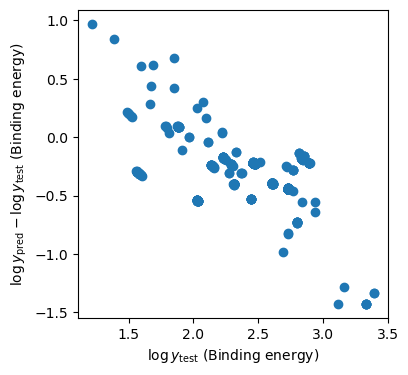

In [92]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.scatter(y_test, y_pred_test-y_test)
ax.set_xlabel(r'$\log{y_\mathrm{test}}$ (Binding energy)')
ax.set_ylabel(r'$\log{y_\mathrm{pred}}-\log{y_\mathrm{test}}$ (Binding energy)')

Text(0, 0.5, '$y_\\mathrm{pred}-y_\\mathrm{test}$ (Binding energy)')

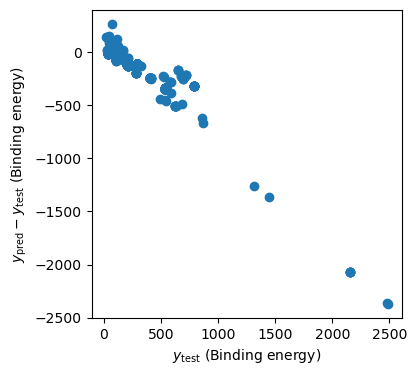

In [93]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.scatter(10 ** y_test, (10 ** y_pred_test) - (10 ** y_test))
ax.set_xlabel(r'$y_\mathrm{test}$ (Binding energy)')
ax.set_ylabel(r'$y_\mathrm{pred}-y_\mathrm{test}$ (Binding energy)')

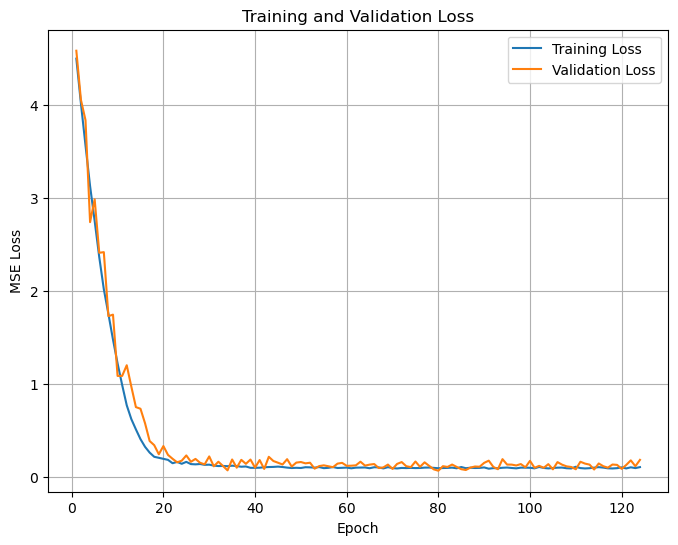

In [94]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()